In [1]:
%load_ext autoreload
%autoreload 2

Setup

In [14]:
import os
os.environ['HF_TOKEN'] = ""

Imports

In [3]:
from vision_retrieval.core import run_vision_inference, search
from vision_retrieval.core import create_db, download_pdf, embedd_docs
from vision_retrieval.core import get_model_colpali, get_model_phi_vision
from vision_retrieval.core import get_query_embedding, base64_to_pil
from vision_retrieval.core import download_pdf

Load models

In [4]:
model_colpali, processor_colpali = get_model_colpali()
model_phi_vision, processor_phi_vision = get_model_phi_vision()

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/models/paligemma/configuration_paligemma.py:137: FutureWarning: The `vocab_size` attribute is deprecated and will be removed in v4.44, Please use `text_config.vocab_size` instead.
  warnings.warn(
`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of ColPali were not initialized from the model checkpoint at google/paligemma-3b-mix-448 and are newly initialized: ['custom_text_proj.bias', 'custom_text_proj.weight', 'language_model.lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/models/auto/image_processing_auto.py:513: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(


Download pdf

In [5]:
download_pdf("https://vision-retrieval.s3.amazonaws.com/docs/InfraRedReport.pdf")

PDF downloaded and saved as ./InfraRedReport.pdf


'./InfraRedReport.pdf'

Create data

In [6]:
docs_to_embed = embedd_docs(["./InfraRedReport.pdf"], model=model_colpali, processor=processor_colpali)

./InfraRedReport.pdf


100%|██████████| 28/28 [00:12<00:00,  2.29it/s]


In [7]:
docs_to_embed[0]['page_embedding'].shape

torch.Size([1030, 128])

In [8]:
db_path = "lancedb"
table_name = "infra-red-table"
create_db(docs_storage=docs_to_embed, table_name=table_name, db_path=db_path)

LanceTable(connection=LanceDBConnection(/teamspace/studios/this_studio/lancedb), name="infra-red-table")

Retrieval

In [11]:
user_query = "How do training costs change over time?"
search_result = search(query=user_query, table_name=table_name, model=model_colpali, processor=processor_colpali, db_path=db_path, top_k=3)

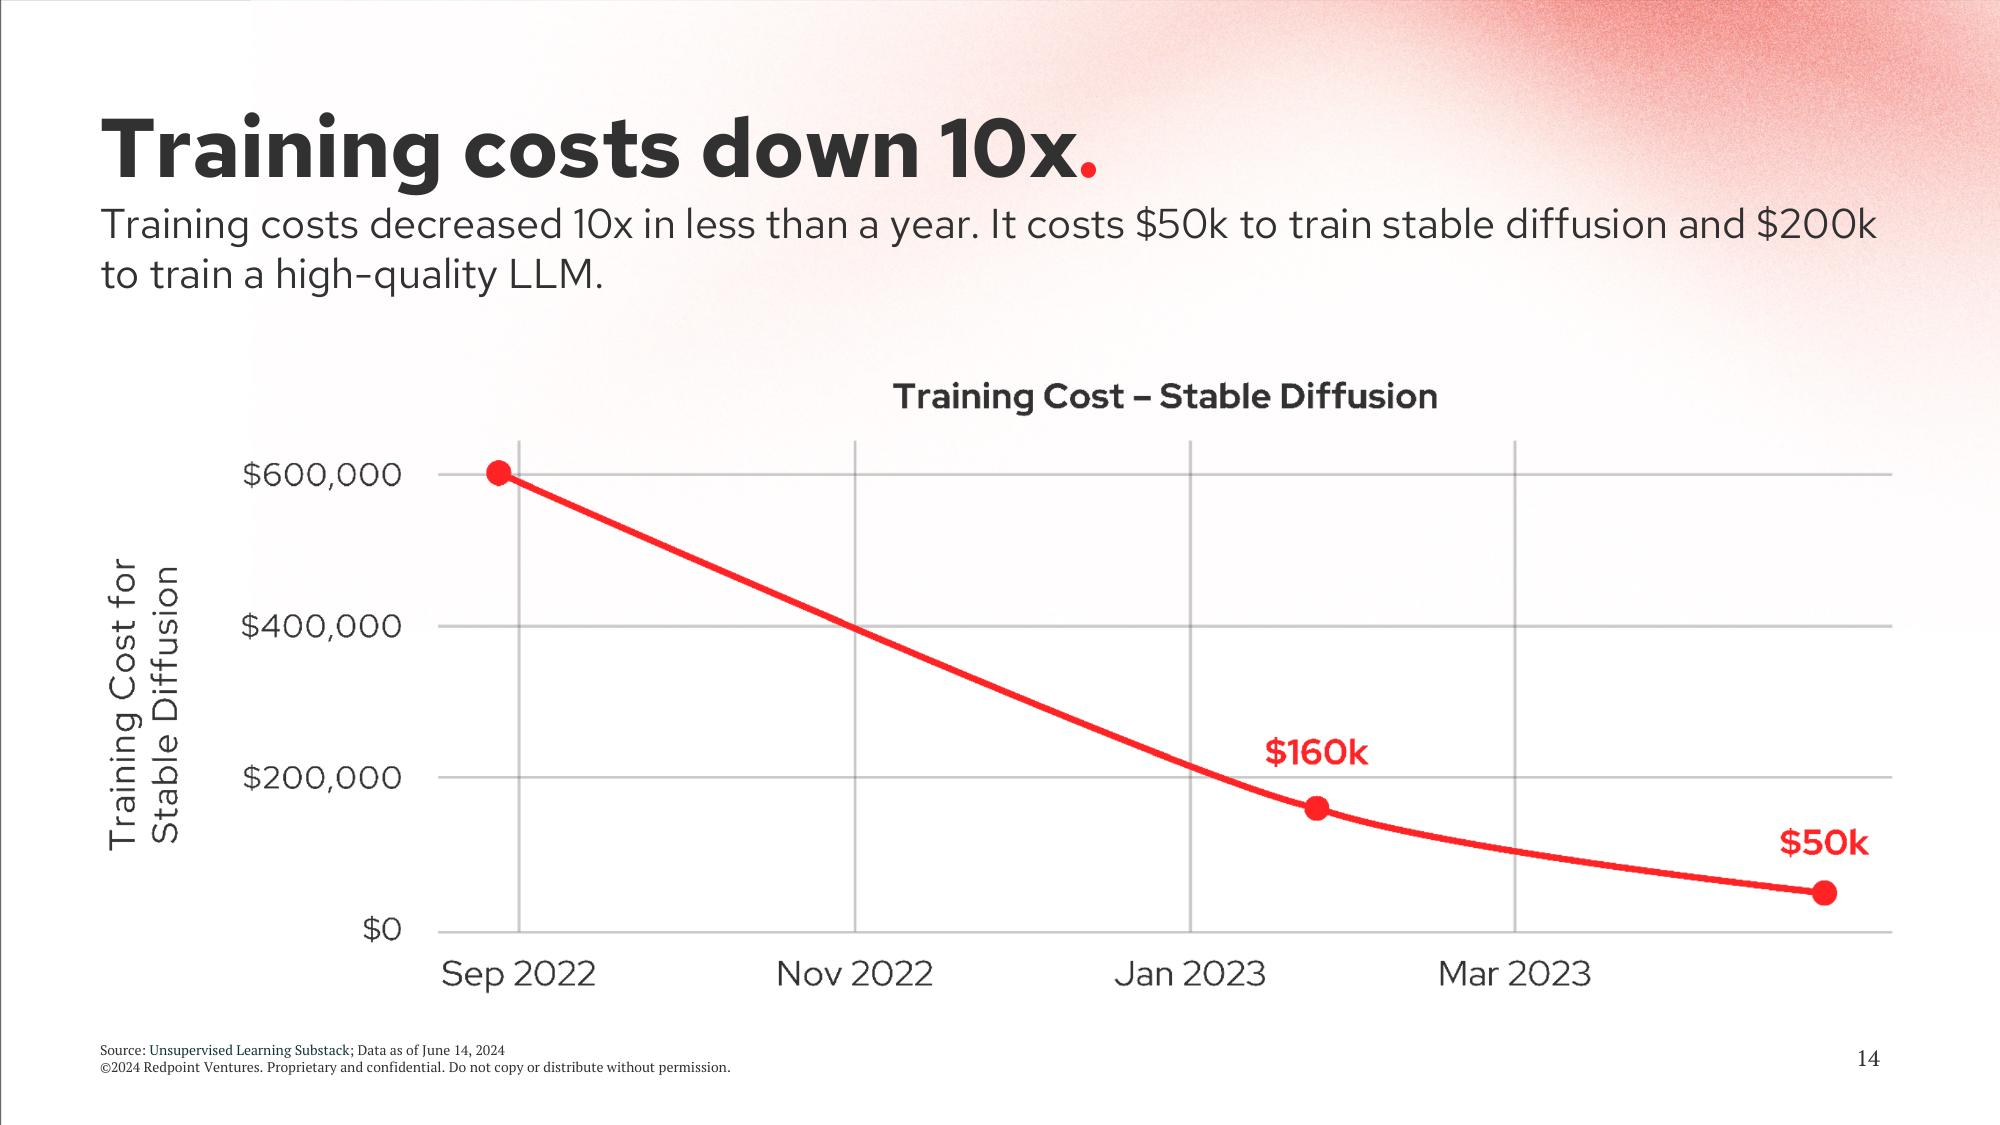

In [12]:
search_result[0]['pil_image']

Augmented Generation

In [13]:
prompt = f"""
Below is a user query, I want you to answer the query using images provided.
user query:
{user_query}
"""

response = run_vision_inference(
    input_images=[search_result[0]['pil_image']], 
    prompt=prompt, 
    model=model_phi_vision, 
    processor=processor_phi_vision
)
print(f"response = {response}")



The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.


response = The training costs for stable diffusion decrease over time. The graph shows a downward trend in training costs from September 2022 to March 2023. In September 2022, the training cost for stable diffusion was $600,000, which decreased to $160,000 in January 2023, and further decreased to $50,000 in March 2023. This indicates that the training costs have decreased by 10x over the period.
